# Classification with an Academic Success Dataset

The academic success dataset includes information related to students' academic paths, demographics and social-economic factors at the time of enrollment in university. The objective of this classification problem is to predict the enrollment status of each student at the end of the normal duration of their course, which can be one of the following:

- Dropout: the student has quit the course
- Enrolled: the student has not completed the course in the expected time
- Graduate: the student has completed the course

This notebook focuses on the application of supervised learning techniques and contains machine learning models capable of making accurate predictions regarding each student's graduation status.


## Exploratory Data Analysis

The following imports are used in this notebook:

- `pandas` and `numpy` for data manipulation and numerical operations.
- `seaborn` and `matplotlib.pyplot` for data visualization.
- `tqdm` for displaying progress bars during model evaluation.
- Scikit-learn modules for preprocessing, model selection, machine learning algorithms, and evaluation metrics.
- `%matplotlib inline` to display plots directly within the notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

We start by reading the CSV file and storing the data, setting the 'id' column as its index.

In [2]:
train = pd.read_csv("data/train.csv",index_col='id')

This is a large dataset, with 76518 rows and 37 columns. It was generated from a deep learning model trained on the original dataset

In [3]:
print("Dataset shape (rows, columns):", train.shape)

Dataset shape (rows, columns): (76518, 37)


In [4]:
print("First 5 rows:")
train.head()

First 5 rows:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


As we can see from the statistical summary, the numeric features of the dataset are not normalized. Most algorithms implemented in this notebook will require normalization.

In [5]:
print("\nStatistical summary:")
train.describe()


Statistical summary:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,...,76518.00000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000
mean,1.111934,16.054419,1.644410,9001.286377,0.915314,3.658760,132.378766,1.226600,19.837633,23.425076,...,0.05796,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921
std,0.441669,16.682337,1.229645,1803.438531,0.278416,8.623774,10.995328,3.392183,15.399456,14.921164,...,0.40849,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,4.000000,...,0.00000,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.00000,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.00000,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000
max,6.000000,53.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.00000,19.000000,23.000000,33.000000,20.000000,18.000000,12.000000,16.200000,3.700000,3.510000


There are no missing values, duplicated rows or incorrect target classes, hence we don't need to clean the data.

In [6]:
print("\nMissing values in each column:")
train.isnull().sum()


Missing values in each column:


Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [7]:
print("\nNumber of duplicate rows:")
print(train.duplicated().sum())

print("\nUnique classes:")
print(train['Target'].unique())


Number of duplicate rows:
0

Unique classes:
['Graduate' 'Dropout' 'Enrolled']


All features of the dataset, except the Target, are of a numeric type (int64 or float64). However, some of them correspond to categorical features which have already been encoded. Therefore, we will need to consult the original documentation to distinguish the categorical from the numeric features.

In [8]:
print("\nDataset information:")
train.info()


Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification

There is not a significant imbalance between the distributions of the Target classes, though graduates make up nearly half of the students in the dataset.

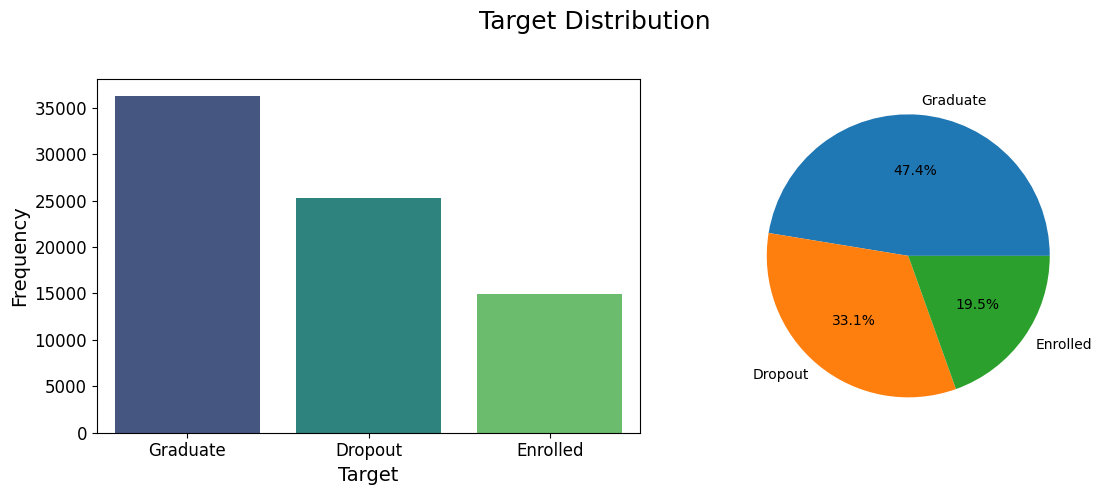

In [9]:
target_counts = train['Target'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
sb.barplot(
    x=target_counts.index,
    y=target_counts.values,
    hue=target_counts.index,
    palette="viridis",
    dodge=False,
    legend=False,
    ax=axes[0]
)
axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Pie chart
axes[1].pie(
    target_counts.values,
    labels=target_counts.index,
    autopct='%1.1f%%'
)

fig.suptitle("Target Distribution", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The categorical features are stored in the cat_vars array. All other attributes are numeric, except for the Target.

In [10]:
cat_vars = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
            'Previous qualification	', 'Nacionality', "Mother's qualification",
            "Father's qualification", "Mother's occupation", "Father's occupation",
            'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
            'Gender', 'Scholarship holder', 'International']

num_features = [col for col in train.columns if col not in cat_vars + ['Target']]

Now we will plot the distributions of the dataset's features. For categorical and integer numeric features, a bar count plot is used, while for float numeric features we'll use an histogram instead.

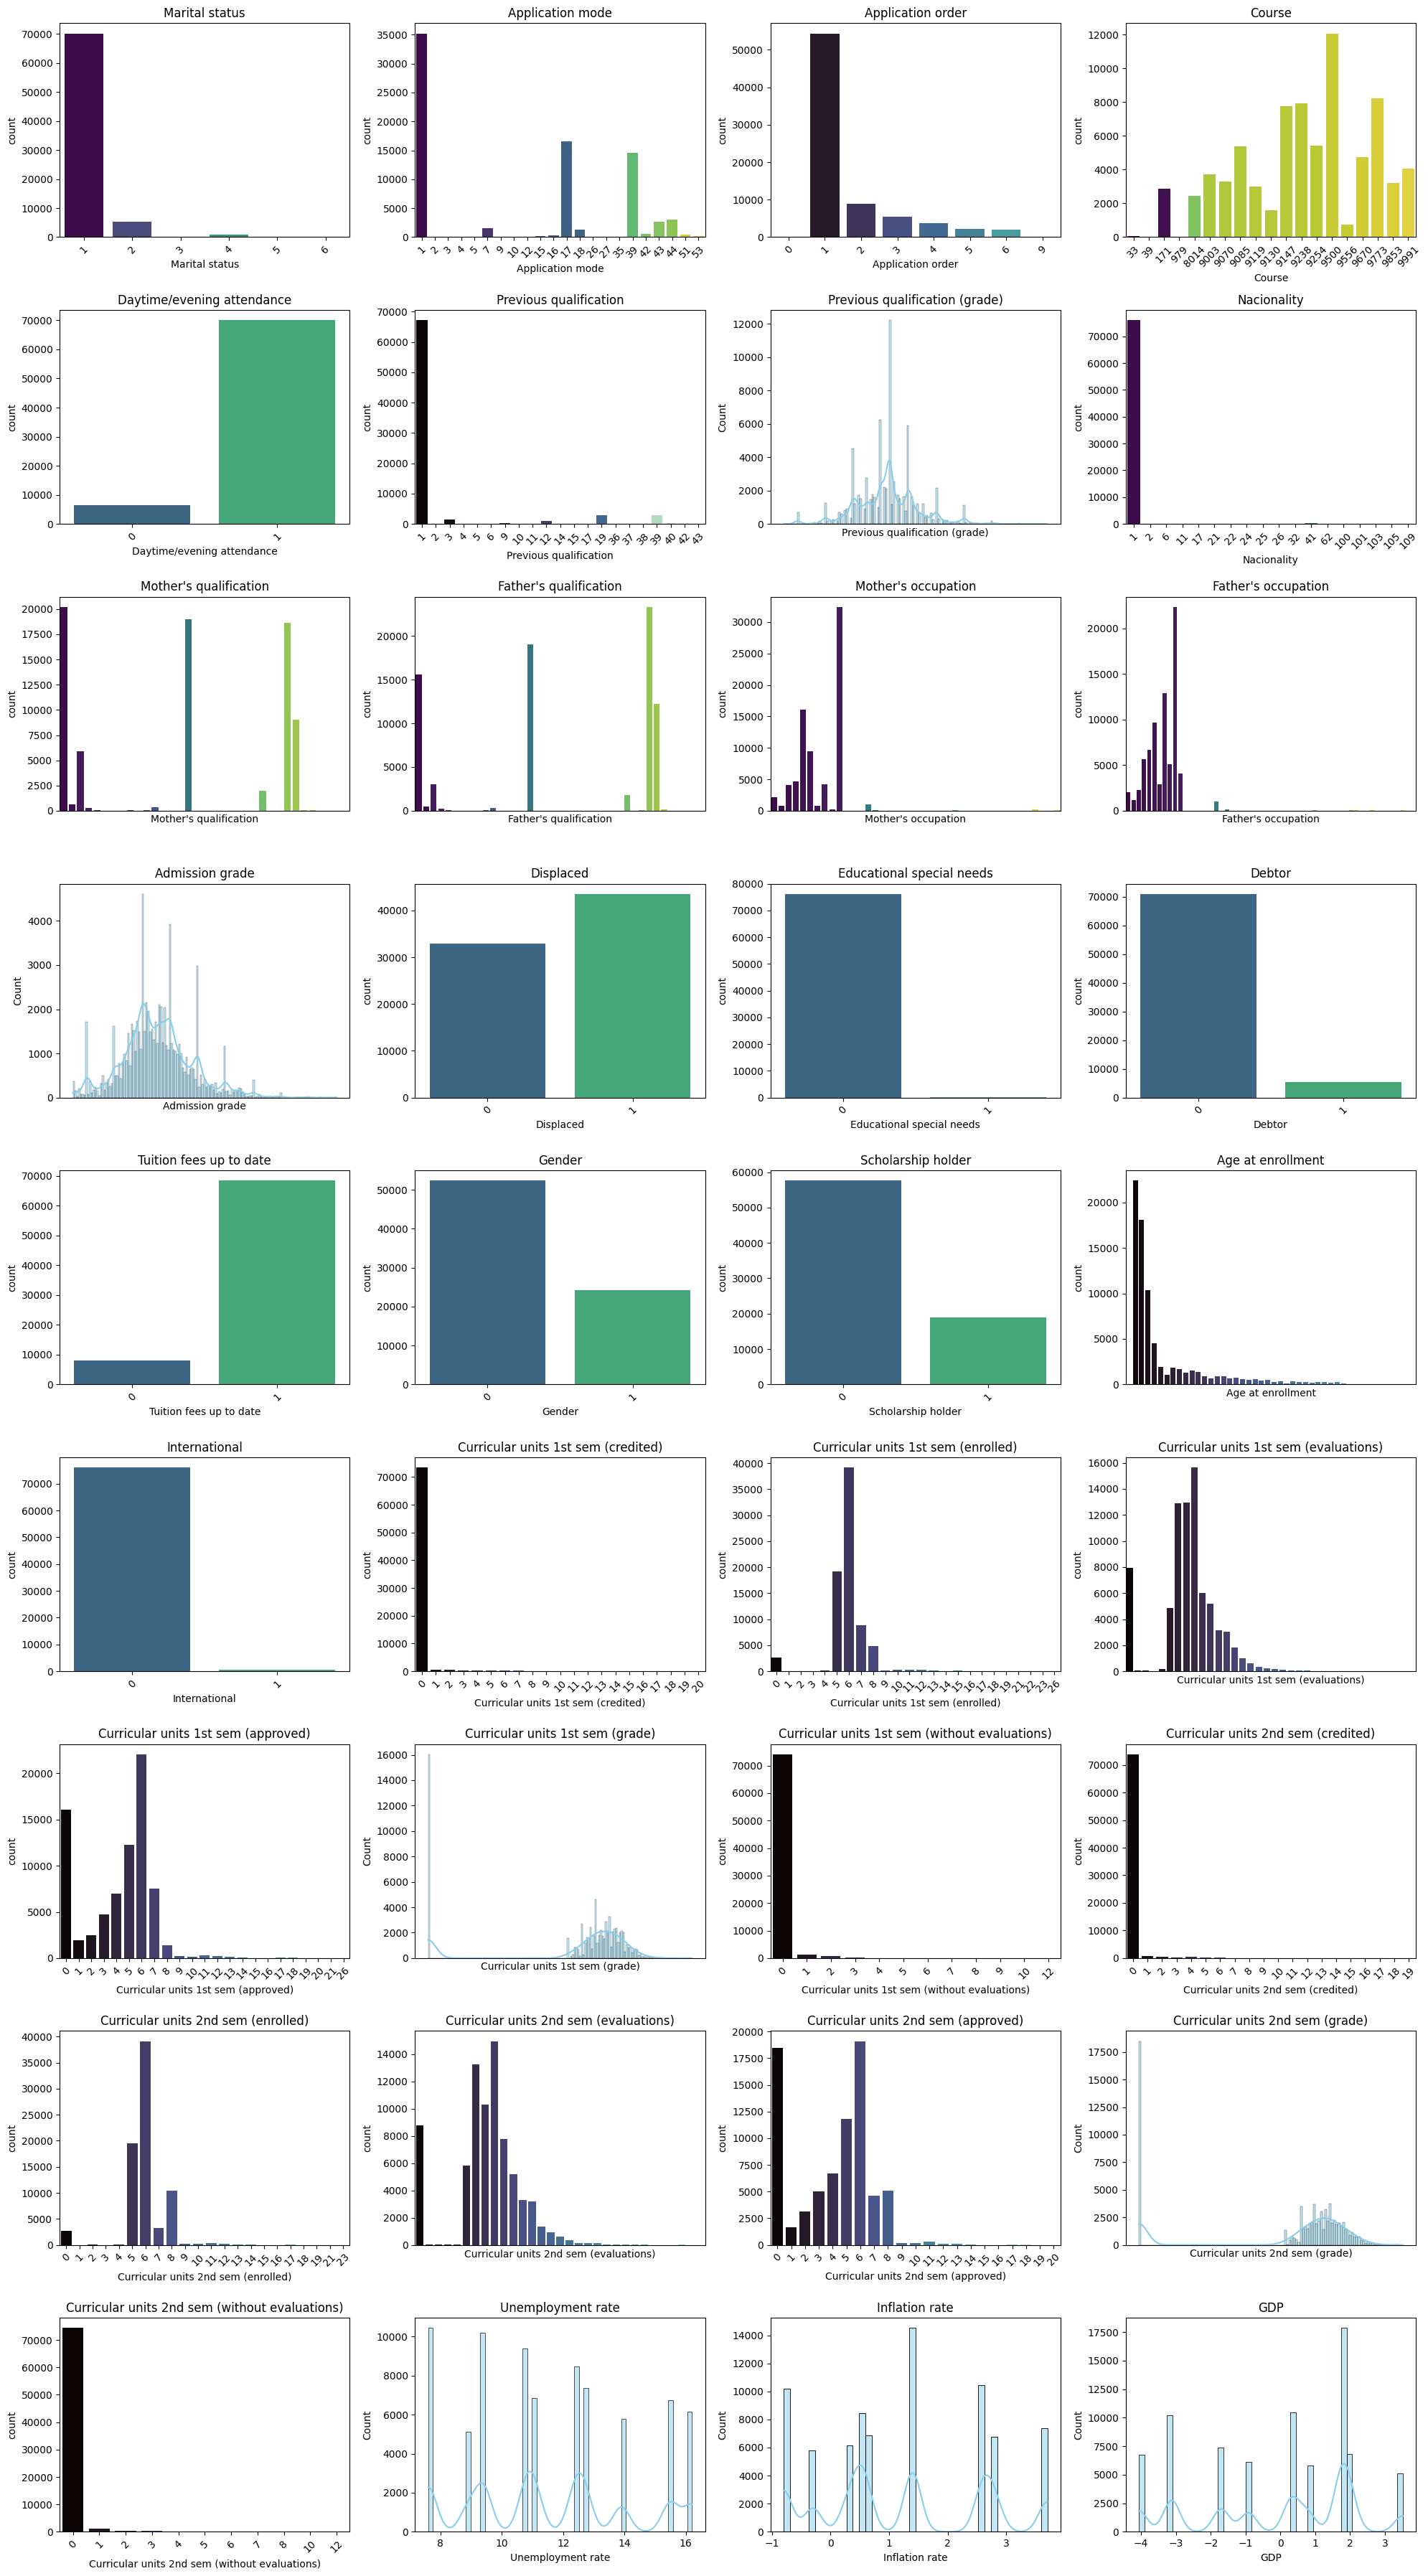

In [11]:
features_to_plot = [col for col in train.columns if col not in ['Target']]

n_cols = 4
n_rows = int(np.ceil(len(features_to_plot) / n_cols))
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for idx, col in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, idx)
    unique_count = train[col].nunique()
    hide_xticks = unique_count > 25

    if col in cat_vars:
        sb.countplot(data=train, x=col, hue=col, palette="viridis", legend=False)
        if hide_xticks:
            plt.xticks([])
        else:
            plt.xticks(rotation=45)
    else:
        if train[col].dtype == 'int64':
            sb.countplot(data=train, x=col, hue=col, palette="mako", legend=False)
            if hide_xticks:
                plt.xticks([])
            else:
                plt.xticks(rotation=45)
        elif train[col].dtype == 'float64':
            sb.histplot(train[col], kde=True, color="skyblue")
            if hide_xticks:
                plt.xticks([])
    plt.title(col)
    plt.tight_layout()

plt.show()

From the above figure we can see that several features, such as 'Marital status' and 'Nationality', are highly imbalanced.

The figure below includes the violin plots of the numeric features of the dataset.

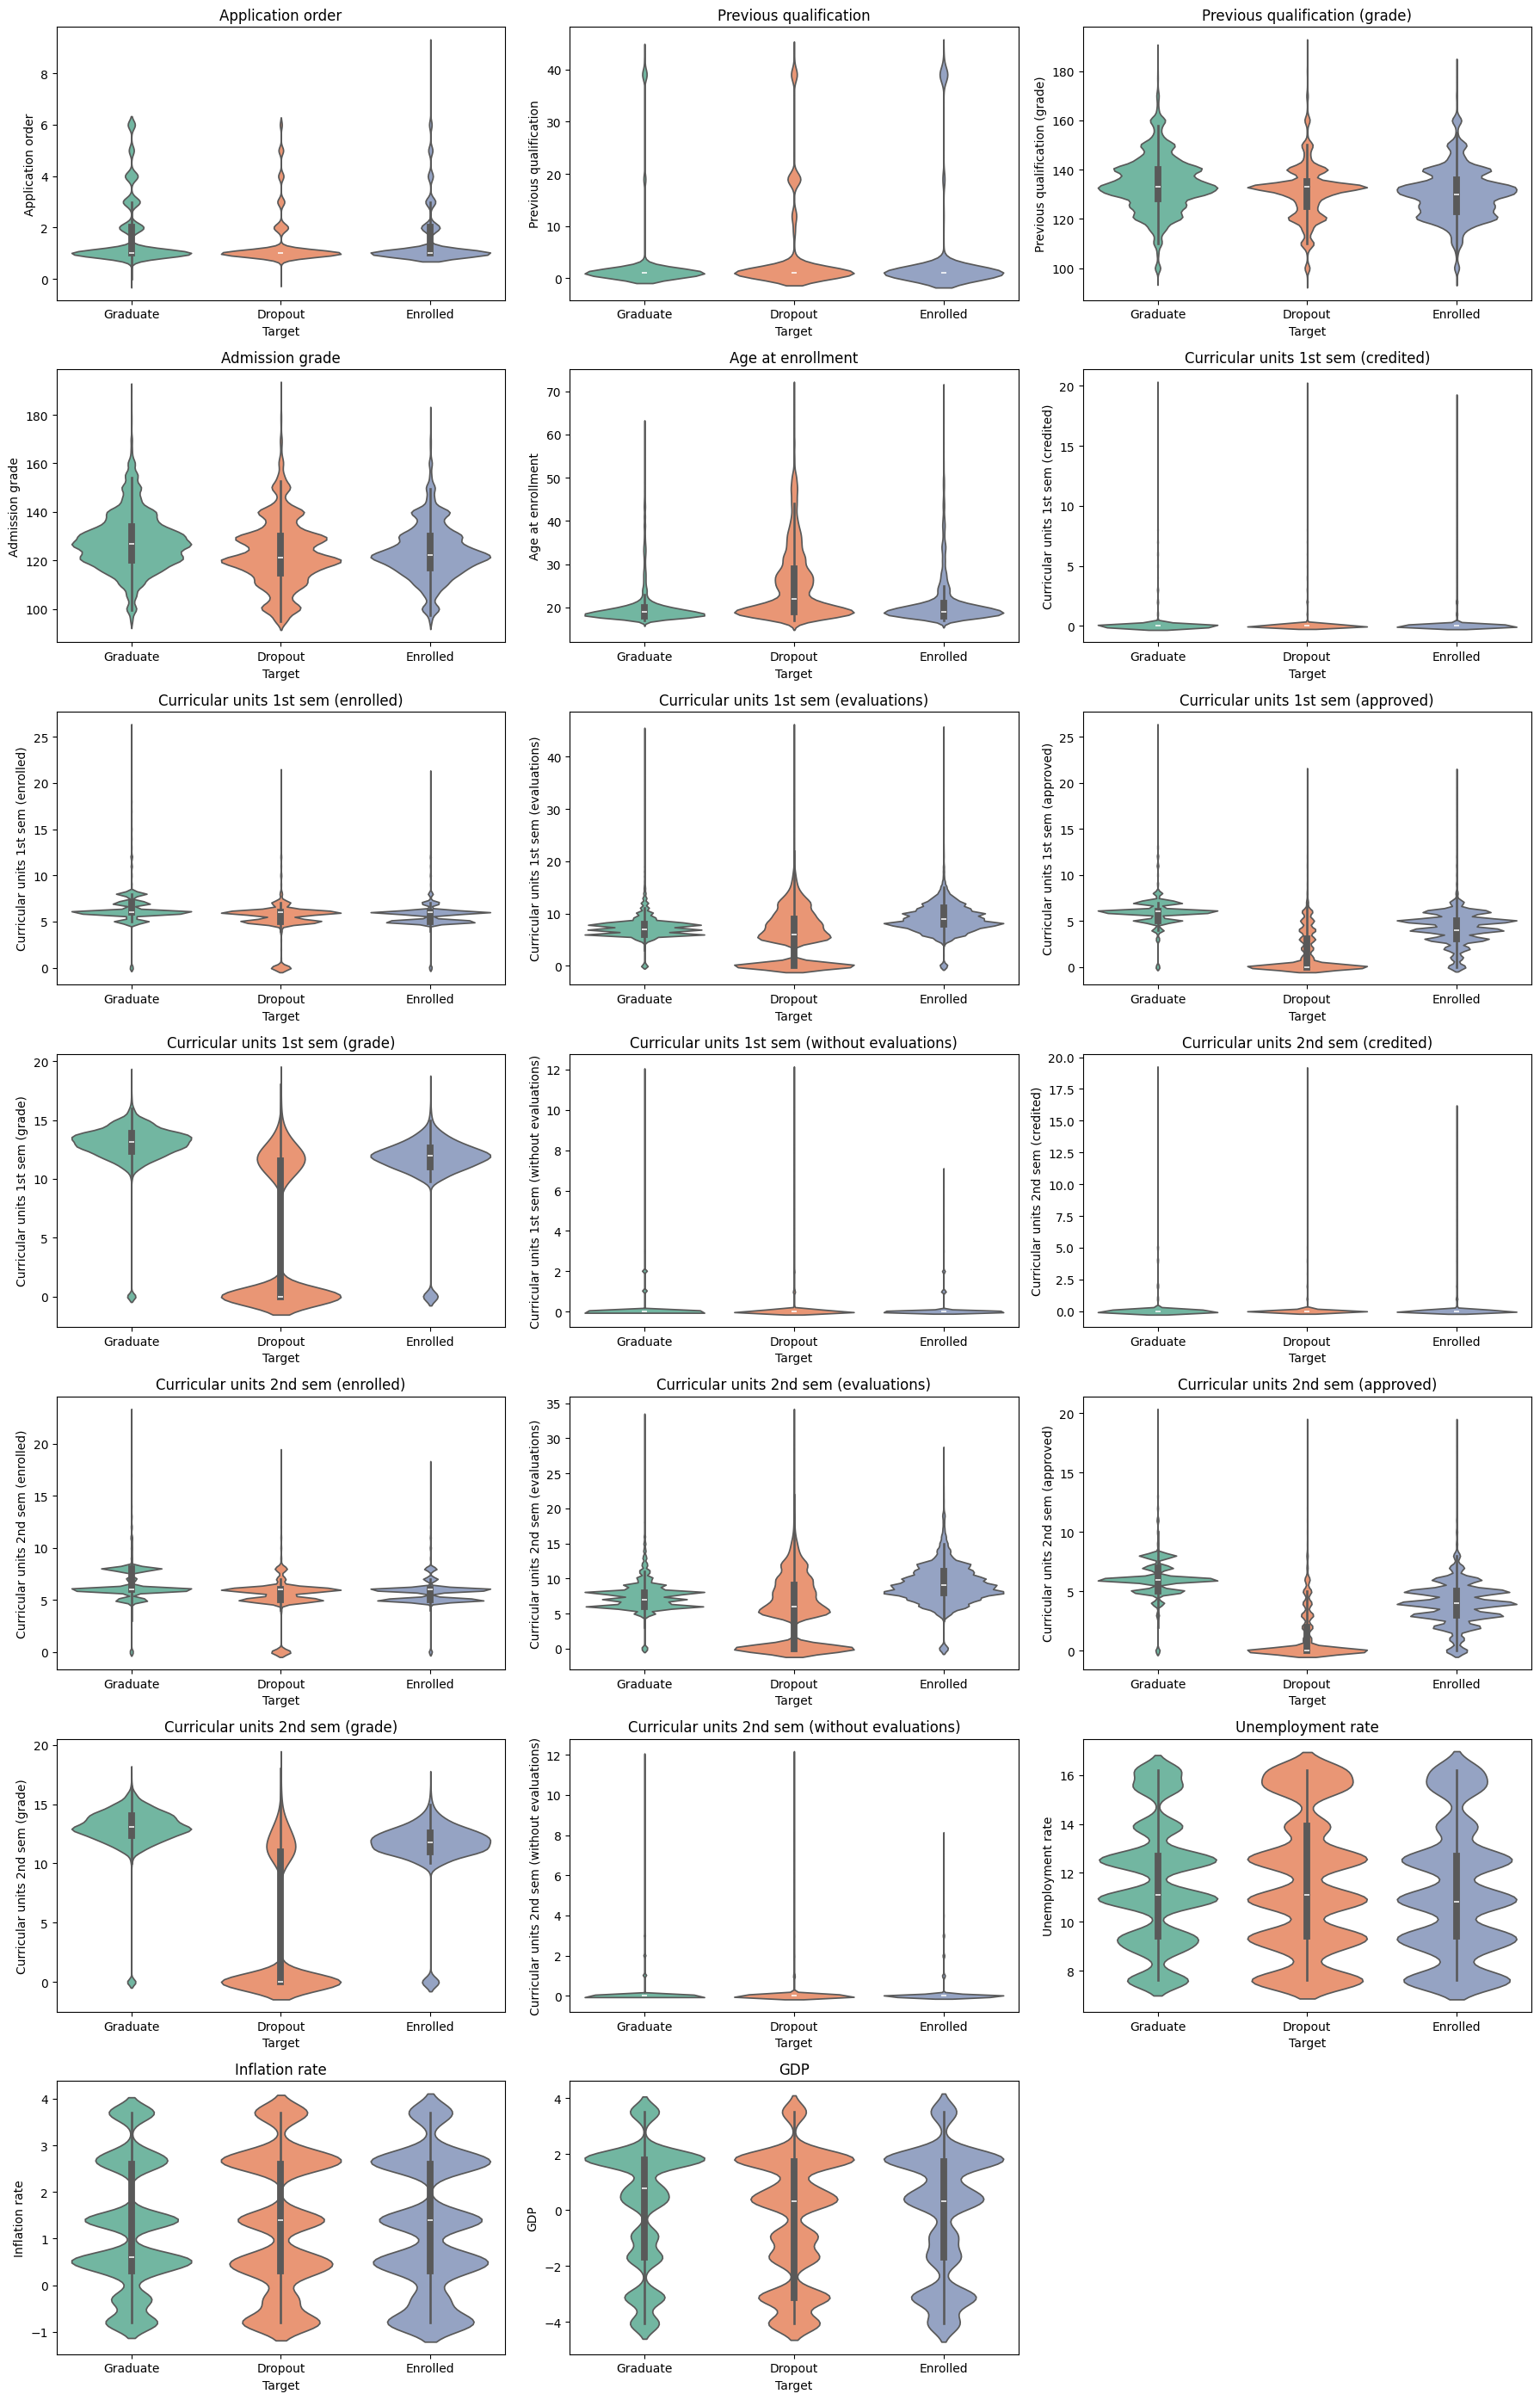

In [12]:
n_cols = 3
n_rows = int(np.ceil(len(num_features) / n_cols))
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for idx, feature in enumerate(num_features, 1):
    plt.subplot(n_rows, n_cols, idx)
    sb.violinplot(data=train, x='Target', y=feature, hue='Target', palette="Set2", legend=False)
    plt.title(feature)

plt.tight_layout()
plt.show()

An interesting observation from the violin plots is that there is not a significant difference in socio-economical features among the different target classes. On the other hand, features related to academic performance, such as grades, are strong differentiators, suggesting that these are more predictice of student outcomes in this dataset.

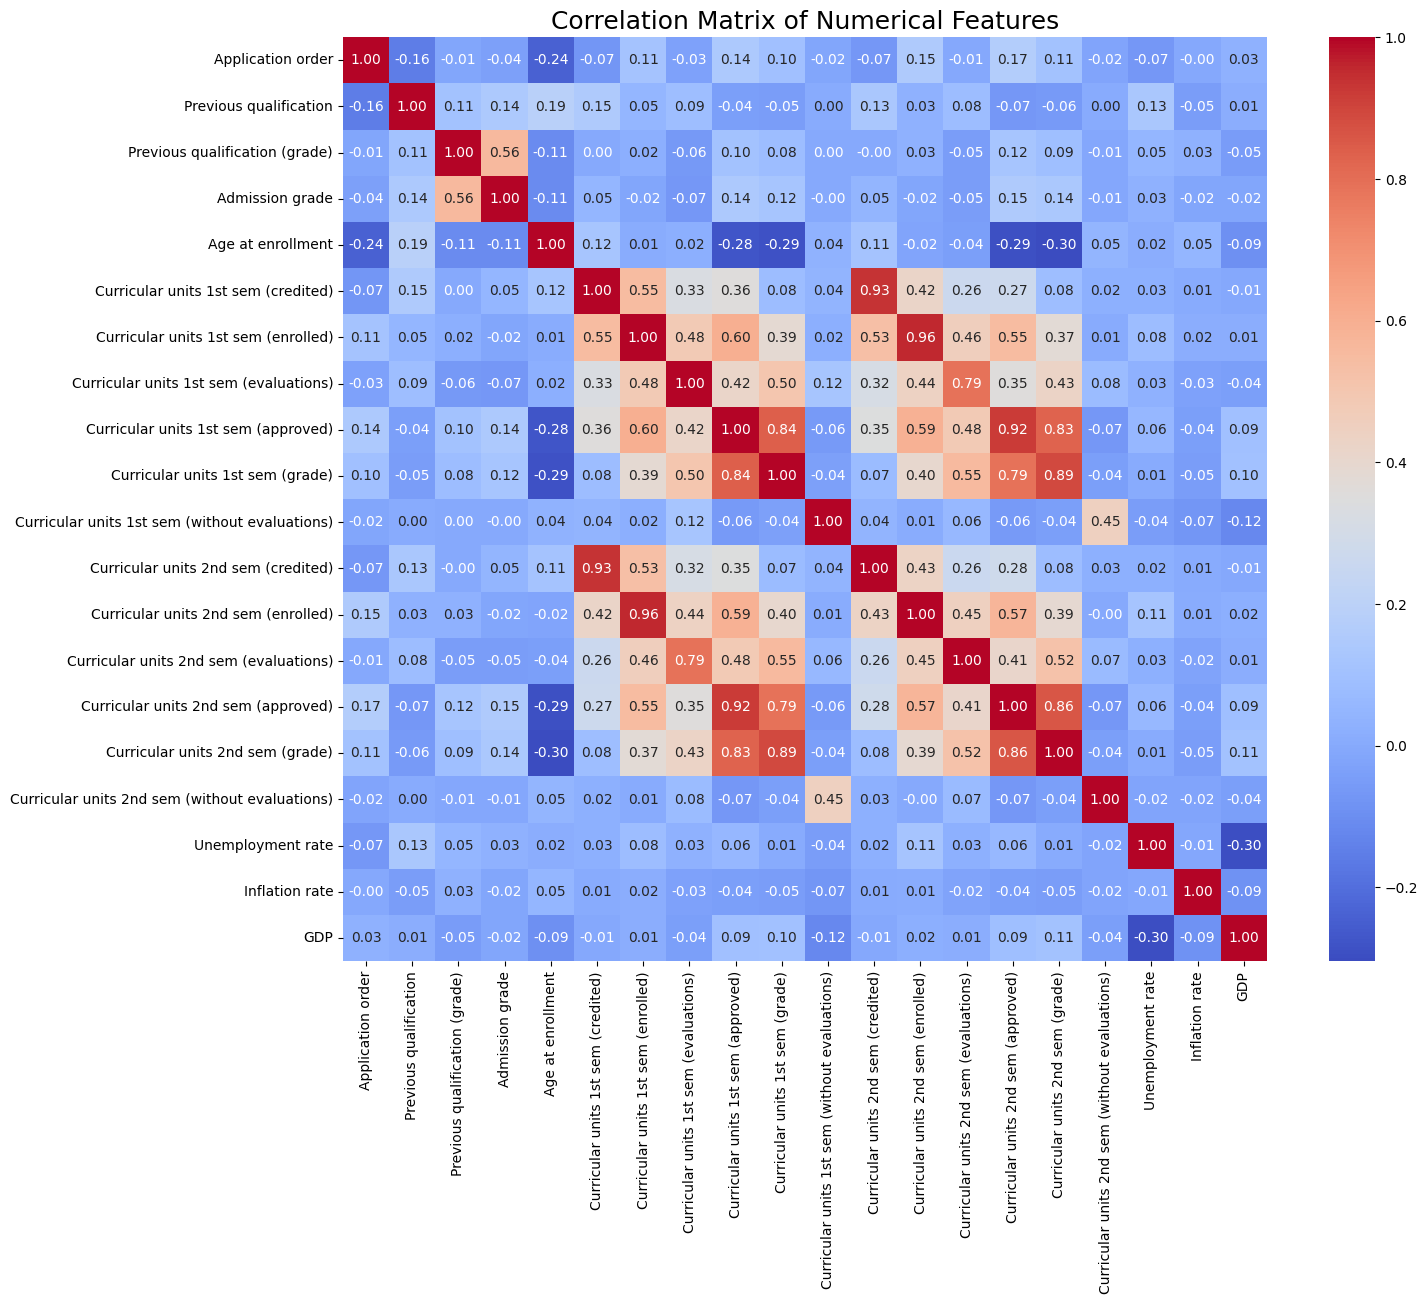

In [13]:
plt.figure(figsize=(16, 12))
corr_matrix = train[num_features].corr()
sb.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numerical Features", fontsize=18)
plt.show()

- There are strong correlations among features related to academic performance.
- Socio-economical features, namely 'Unemployment rate', 'Inflation rate' and 'GDP', have very low correlation with all other features. The same happens with 'Age at enrollment' and 'Application order'.

## Data Preprocessing

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])
print(train['Target'].unique())

[2 0 1]


In [15]:
from sklearn.model_selection import train_test_split

X = train.drop('Target', axis=1)
y = train['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Train set shape: (61214, 36)
Test set shape: (15304, 36)


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_s = X_train.copy()
X_test_s = X_test.copy()

X_train_s[num_features] = scaler.fit_transform(X_train[num_features])
X_test_s[num_features] = scaler.transform(X_test[num_features])

socio_econ_features = ['Unemployment rate', 'Inflation rate', 'GDP']
num_features_wo_socio = [f for f in num_features if f not in socio_econ_features]

X_train_wo_socio = X_train.drop(socio_econ_features, axis=1)
X_test_wo_socio = X_test.drop(socio_econ_features, axis=1)

scaler_wo_socio = StandardScaler()
X_train_s_wo_socio = X_train_wo_socio.copy()
X_test_s_wo_socio = X_test_wo_socio.copy()
X_train_s_wo_socio[num_features_wo_socio] = scaler_wo_socio.fit_transform(X_train_wo_socio[num_features_wo_socio])
X_test_s_wo_socio[num_features_wo_socio] = scaler_wo_socio.transform(X_test_wo_socio[num_features_wo_socio])

## Models

### k-Nearest Neighbors (k-NN)

#### Without feature selection

Evaluating k values: 100%|██████████| 30/30 [01:43<00:00,  3.45s/it]


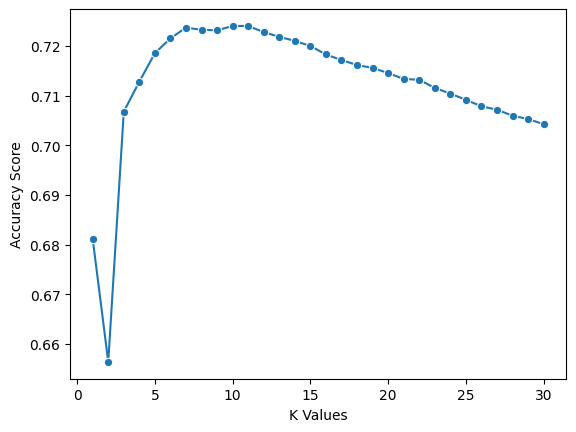

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,31)]
scores = []

for k in tqdm(k_values, desc="Evaluating k values"):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_s, y_train, cv=5, n_jobs=-1)
    scores.append(np.mean(score))

sb.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

plt.show()

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_s, y_train)

y_pred = knn.predict(X_test_s)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)

Accuracy: 0.7319654992158913
Precision: 0.7243736915723713
Recall: 0.7319654992158913
F1 Score: 0.7243155977734793
Confusion Matrix:
 [[3667  628  764]
 [ 484 1210 1294]
 [ 368  564 6325]]


#### With feature selection

Evaluating k values: 100%|██████████| 30/30 [01:38<00:00,  3.29s/it]


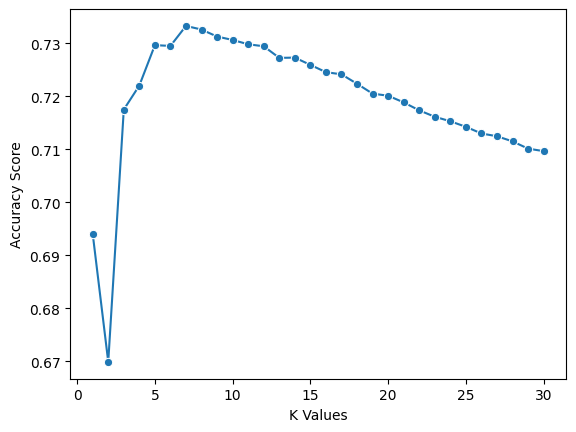

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,31)]
scores = []

for k in tqdm(k_values, desc="Evaluating k values"):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_s_wo_socio, y_train, cv=5, n_jobs=-1)
    scores.append(np.mean(score))

sb.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

plt.show()

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_s_wo_socio, y_train)

y_pred = knn.predict(X_test_s_wo_socio)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)

Accuracy: 0.73882645060115
Precision: 0.7334283908597292
Recall: 0.73882645060115
F1 Score: 0.7336558753039935
Confusion Matrix:
 [[3705  688  666]
 [ 487 1308 1193]
 [ 358  605 6294]]


### Decision Tree

Evaluating max_depths: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


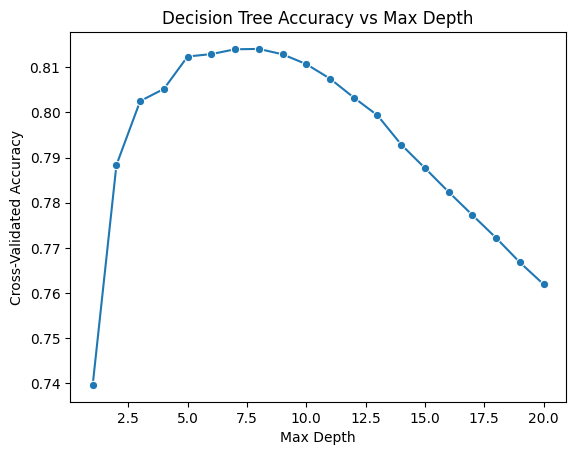

In [21]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

max_depths = range(1, 21)
dt_scores = []

for depth in tqdm(max_depths, desc="Evaluating max_depths"):
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    score = cross_val_score(dt, X_train, y_train, cv=5)
    dt_scores.append(np.mean(score))

sb.lineplot(x=max_depths, y=dt_scores, marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Decision Tree Accuracy vs Max Depth")
plt.show()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

best_depth = int(np.argmax(dt_scores)) + 1
dt_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_best.fit(X_train, y_train)
y_pred_dt = dt_best.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("Best max_depth:", best_depth)
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)
print("Confusion Matrix:\n", cm_dt)

Best max_depth: 8
Accuracy: 0.8139048614741244
Precision: 0.8149393684401335
Recall: 0.8139048614741244
F1 Score: 0.812239220489856
Confusion Matrix:
 [[4036  635  388]
 [ 309 1747  932]
 [ 104  480 6673]]


### Multi-layer Perceptron (MLP) Classifier

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

mlp_hidden_sizes = [(50,), (100,), (150,), (100, 50), (100, 100)]
mlp_scores = []
for h in tqdm(mlp_hidden_sizes, desc="Evaluating hidden_layer_sizes"):
    mlp = MLPClassifier(hidden_layer_sizes=h, max_iter=100, random_state=42)
    score = cross_val_score(mlp, X_train_s, y_train, cv=3)
    mlp_scores.append(np.mean(score))

Evaluating hidden_layer_sizes:  60%|██████    | 3/5 [00:24<00:17,  8.69s/it]/home/magui/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
Evaluating hidden_layer_sizes: 100%|██████████| 5/5 [01:22<00:00, 16.51s/it]


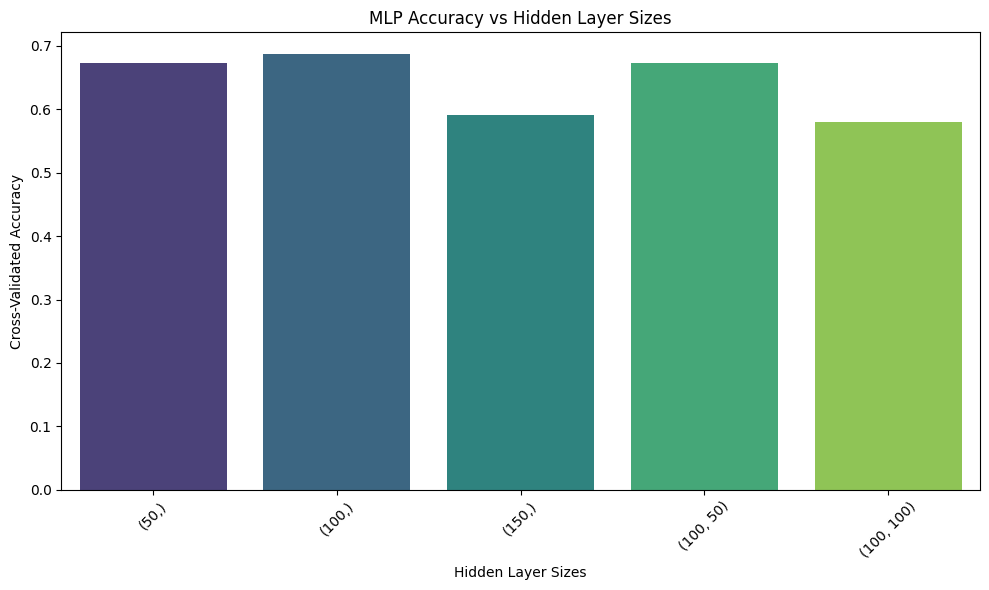

In [24]:
results_df = pd.DataFrame({
    "Hidden Layer Sizes": [str(h) for h in mlp_hidden_sizes],
    "Accuracy": mlp_scores
})

plt.figure(figsize=(10, 6))
sb.barplot(data=results_df, x="Hidden Layer Sizes", y="Accuracy", hue="Hidden Layer Sizes", dodge=False, palette="viridis", legend=False)
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Cross-Validated Accuracy")
plt.title("MLP Accuracy vs Hidden Layer Sizes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Cross-validation Results (cv=5):
Scores: [0.82703868 0.82625457 0.82573183 0.82872639 0.82186499]
Mean Accuracy: 0.8259232957578059
Cross-validation time: 49.8368 seconds

🔍 Random Forest Classifier Test Results
Training time: 9.2678 seconds
Testing time: 0.3169 seconds
Accuracy: 0.8278227914270779
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      5059
           1       0.65      0.59      0.62      2988
           2       0.85      0.93      0.89      7257

    accuracy                           0.83     15304
   macro avg       0.80      0.78      0.79     15304
weighted avg       0.83      0.83      0.83     15304

Confusion Matrix:
 [[4172  540  347]
 [ 365 1765  858]
 [ 119  406 6732]]


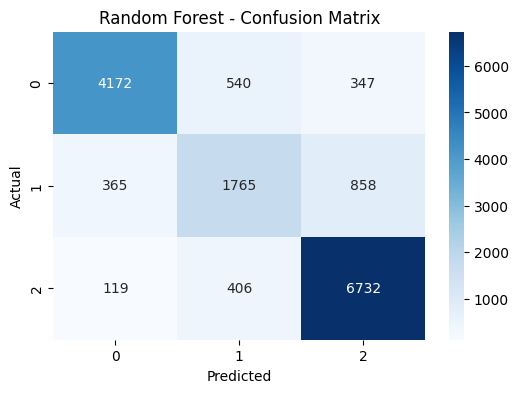

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Instanciar o modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Validação cruzada (cv=5)
start_cv = time.time()
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
end_cv = time.time()

print("Cross-validation Results (cv=5):")
print("Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print(f"Cross-validation time: {end_cv - start_cv:.4f} seconds")

# Treinar uma única vez no conjunto de treino
start_train = time.time()
rf_model.fit(X_train, y_train)
end_train = time.time()

# Prever no conjunto de teste
start_test = time.time()
y_pred = rf_model.predict(X_test)
end_test = time.time()

# Avaliação final
print("\n Random Forest Classifier Test Results")
print(f"Training time: {end_train - start_train:.4f} seconds")
print(f"Testing time: {end_test - start_test:.4f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Heatmap da matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time


# Treinar modelo
start_train = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
end_train = time.time()

# Testar modelo
start_test = time.time()
y_pred = rf_model.predict(X_test)
end_test = time.time()

# Avaliação
print("Random Forest Classifier Results")
print(f"Training time: {end_train - start_train:.4f} seconds")
print(f"Testing time: {end_test - start_test:.4f} seconds")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')



Random Forest Classifier Results
Training time: 9.4099 seconds
Testing time: 0.3065 seconds
Accuracy: 0.8278227914270779
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      5059
           1       0.65      0.59      0.62      2988
           2       0.85      0.93      0.89      7257

    accuracy                           0.83     15304
   macro avg       0.80      0.78      0.79     15304
weighted avg       0.83      0.83      0.83     15304

Confusion Matrix:
 [[4172  540  347]
 [ 365 1765  858]
 [ 119  406 6732]]


### Logistic Regression

Evaluating C values:   0%|          | 0/6 [00:00<?, ?it/s]/home/magui/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/magui/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

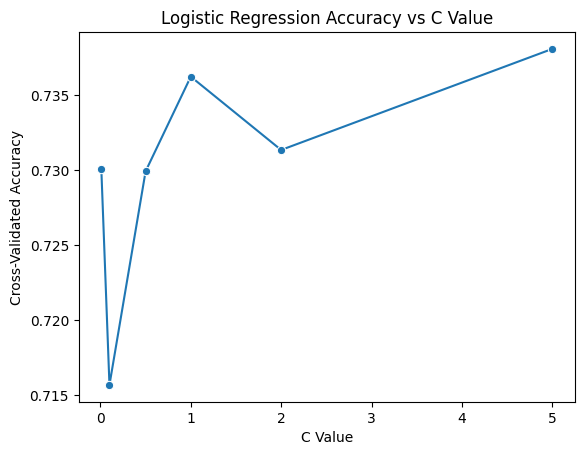

In [27]:
# Try different C values for Logistic Regression and plot accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr_C_values = [0.01, 0.1, 0.5, 1, 2, 5]
lr_scores = []

for c in tqdm(lr_C_values, desc="Evaluating C values"):
    lr = LogisticRegression(C=c, max_iter=200, random_state=42)
    score = cross_val_score(lr, X_train_s, y_train, cv=3)
    lr_scores.append(np.mean(score))

sb.lineplot(x=lr_C_values, y=lr_scores, marker='o')
plt.xlabel("C Value")
plt.ylabel("Cross-Validated Accuracy")
plt.title("Logistic Regression Accuracy vs C Value")
plt.show()

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=200, random_state=42)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)
print("Confusion Matrix:\n", cm_lr)

Accuracy: 0.7425509670674334
Precision: 0.7221084056514693
Recall: 0.7425509670674334
F1 Score: 0.7163077492199583
Confusion Matrix:
 [[3836  469  754]
 [ 557  715 1716]
 [ 225  219 6813]]


/home/magui/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Overall Analysis and Comparison of Algorithms

In [29]:
# Collect metrics for each algorithm
# SVM is commented out due to long training time
summary_df = pd.DataFrame({
    'Algorithm': [
        'Decision Tree',
        'MLP',
        'k-NN',
        'Logistic Regression',
        'Random Forest Classifier'
    ],
    'Accuracy': [
        accuracy_dt,
        accuracy_mlp,
        accuracy,  # k-NN
        accuracy_lr,
        accuracy_rf
    ],
    'Precision': [
        precision_dt,
        precision_mlp,
        precision,  # k-NN
        precision_lr,
        precision_rf
    ],
    'Recall': [
        recall_dt,
        recall_mlp,
        recall,  # k-NN
        recall_lr,
        recall_rf
    ],
    'F1 Score': [
        f1_dt,
        f1_mlp,
        f1,  # k-NN
        f1_lr,
        f1_rf
    ]
})
summary_df

NameError: name 'accuracy_mlp' is not defined

In [ ]:
# Plot comparison of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(12, 7))
summary_melted = summary_df.melt(id_vars='Algorithm', value_vars=metrics, var_name='Metric', value_name='Score')
sb.barplot(data=summary_melted, x='Metric', y='Score', hue='Algorithm', palette='viridis')
plt.title('Comparison of Classification Algorithms')
plt.ylim(0, 1)
plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize confusion matrices for all algorithms
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
algorithms = ['Decision Tree', 'MLP', 'k-NN', 'SVM', 'Logistic Regression']
cms = [cm_dt, cm_mlp, cm, cm_lr]
for ax, name, cmatrix in zip(axes, algorithms, cms):
    disp = ConfusionMatrixDisplay(cmatrix)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)
plt.suptitle('Confusion Matrices of All Algorithms', fontsize=16)
plt.tight_layout()
plt.show()